## Import Libraries and Load Data

In [ ]:
from collections import defaultdict
from datetime import datetime
import gzip
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from typing import Dict, Any, Tuple
import warnings
import hashlib

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


In [ ]:
DATA_FILE = '../data/dataset0.json.gz'
LABELS_FILE = '../data/data.info.labelled'

def load_data(data_file, labels_file):
    """Load dataset"""
    print("Loading dataset...")
    rows = []
    
    with gzip.open(data_file, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)
    
    with gzip.open(data_file, 'rt', encoding='utf-8') as f:
        for line in tqdm(f, total=total_lines, desc="Loading data"):
            data = json.loads(line)
            for transcript_id, positions in data.items():
                for transcript_position, sequences in positions.items():
                    for sequence, feature_list in sequences.items():
                        for features in feature_list:
                            rows.append({
                                'transcript_id': transcript_id,
                                'transcript_position': int(transcript_position),
                                'dwell_-1': features[0],
                                'std_-1': features[1],
                                'mean_-1': features[2],
                                'dwell_0': features[3],
                                'std_0': features[4],
                                'mean_0': features[5],
                                'dwell_+1': features[6],
                                'std_+1': features[7],
                                'mean_+1': features[8],
                            })
    
    df = pd.DataFrame(rows)
    labels = pd.read_csv(labels_file)
    
    print(f"Loaded {len(df)} reads from {len(df.groupby(['transcript_id', 'transcript_position']))} sites")
    return df, labels

# Load data
df, labels = load_data(DATA_FILE, LABELS_FILE)
print(f"\nData shape: {df.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nFirst few rows:")
df.head()

,transcript_id,transcript_position,sequence,dwell_-1,std_-1,mean_-1,dwell_0,std_0,mean_0,dwell_+1,std_+1,mean_+1,gene_id,label
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,ENSG00000004059,0
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,ENSG00000004059,0
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,ENSG00000004059,0
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,ENSG00000004059,0
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,ENSG00000004059,0


## Data Preprocessing

In [ ]:
BASE2IDX = {'A':0, 'C':1, 'G':2, 'T':3, 'U':3}
PAD_IDX = 4

def seq_to_idx7(s: str):
    s = str(s).upper().replace('U', 'T')
    assert len(s) == 7, f"Expected 7-mer, got {s} (len={len(s)})"
    return np.array([BASE2IDX.get(ch, 0) for ch in s], dtype=np.int64)

site_key = ['transcript_id', 'transcript_position']
num_cols = [
    'dwell_-1','std_-1','mean_-1','dwell_0','std_0','mean_0',
    'dwell_+1','std_+1','mean_+1'
]
seq_col = 'sequence'  
label_col = 'label'

def split_by_gene(df, test_size=0.2, val_size=0.1, random_state=42):
    """Split data by gene_id to avoid data leakage"""
    unique_genes = df['gene_id'].unique()
    
    train_val_genes, test_genes = train_test_split(
        unique_genes, 
        test_size=test_size, 
        random_state=random_state
    )
    
    train_genes, val_genes = train_test_split(
        train_val_genes, 
        test_size=val_size/(1-test_size),
        random_state=random_state
    )
    
    train_df = df[df['gene_id'].isin(train_genes)].copy()
    val_df = df[df['gene_id'].isin(val_genes)].copy()
    test_df = df[df['gene_id'].isin(test_genes)].copy()
    
    print(f"Train genes: {len(train_genes)}, Val genes: {len(val_genes)}, Test genes: {len(test_genes)}")
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")
    
    return train_df, val_df, test_df

def scale_features(train_df, val_df, test_df, num_cols):
    """Scale numeric features using StandardScaler fit on training data only"""
    data_scaler = StandardScaler()
    
    train_df[num_cols] = data_scaler.fit_transform(train_df[num_cols])
    val_df[num_cols] = data_scaler.transform(val_df[num_cols])
    test_df[num_cols] = data_scaler.transform(test_df[num_cols])
    
    return train_df, val_df, test_df, data_scaler

def create_bags(df, site_key, num_cols, seq_col, label_col, min_reads=5, max_reads=50):
    bags = []
    grouped = df.groupby(site_key)

    for site, group in grouped:
        if len(group) < min_reads:
            continue

        features = group[num_cols].to_numpy(dtype=np.float32)
        sequences = group[seq_col].astype(str).tolist()
        seq_idx = np.vstack([seq_to_idx7(s) for s in sequences])

        labels = group[label_col].to_numpy()
        site_label = int(labels[0])

        if len(features) > max_reads:
            idx = np.random.choice(len(features), max_reads, replace=False)
            features = features[idx]
            seq_idx  = seq_idx[idx]

        bags.append({
            'site': site,
            'transcript_id': site[0],
            'transcript_position': int(site[1]),
            'features': features,
            'seq_idx': seq_idx,
            'n_reads': len(features),
            'label': site_label,
            'gene_id': group['gene_id'].iloc[0],
        })

    print(f"Created {len(bags)} bags from {len(grouped)} sites")
    return bags

def preprocess_data(df):
    """Complete preprocessing pipeline"""
    train_df, val_df, test_df = split_by_gene(df)
    train_df, val_df, test_df, scaler = scale_features(train_df, val_df, test_df, num_cols)
    
    train_bags = create_bags(train_df, site_key, num_cols, seq_col, label_col)
    val_bags = create_bags(val_df, site_key, num_cols, seq_col, label_col)
    test_bags = create_bags(test_df, site_key, num_cols, seq_col, label_col)
    
    print("\nBag statistics:")
    for name, bags in [("Train", train_bags), ("Val", val_bags), ("Test", test_bags)]:
        n_positive = sum(1 for bag in bags if bag['label'] == 1)
        avg_reads = np.mean([bag['n_reads'] for bag in bags])
        print(f"{name}: {len(bags)} bags, {n_positive} positive ({n_positive/len(bags)*100:.1f}%), "
              f"avg {avg_reads:.1f} reads/bag")
    
    return train_bags, val_bags, test_bags, scaler


class RNA_MIL_Dataset(Dataset):
    """
    Dataset with positive bag oversampling support.
    Yields: x_num [B, bag_size, 9], x_seq [B, bag_size, 7], mask [B, bag_size], y [B]
    """
    def __init__(self, bags, bag_size=40, is_train=True, pad_idx=PAD_IDX, oversample_positive=False, oversample_factor=10):
        self.bags = bags
        self.bag_size = bag_size
        self.is_train = is_train
        self.pad_idx = pad_idx

        if is_train and oversample_positive:
            pos_bags = [b for b in bags if b['label'] == 1]
            neg_bags = [b for b in bags if b['label'] == 0]
            print(f"Original: {len(pos_bags)} positive, {len(neg_bags)} negative bags")
            self.bags = neg_bags + pos_bags * oversample_factor
            print(f"After oversampling ({oversample_factor}x): {len(self.bags)} total bags")

        self.proc = []
        self.labels = []

        for bag in self.bags:
            num = bag['features']
            seq = bag['seq_idx']
            n = bag['n_reads']
            if n == 0:
                continue

            if n < bag_size:
                pad_num = np.zeros((bag_size - n, num.shape[1]), dtype=np.float32)
                pad_seq = np.full((bag_size - n, seq.shape[1]), self.pad_idx, dtype=np.int64)
                num_fixed = np.vstack([num, pad_num])
                seq_fixed = np.vstack([seq, pad_seq])
                mask = np.zeros(bag_size, dtype=np.float32)
                mask[:n] = 1.0
            else:
                # If there are more reads than bag_size, sample a subset.
                # Training: stochastic random sampling;
                # Validation/Test: deterministic pseudo-random sampling based on site key so evaluation is repeatable but not biased by first-N reads.
                if n > bag_size:
                    if self.is_train:
                        idx = np.random.choice(n, bag_size, replace=False)
                    else:
                        # deterministic seed derived from transcript_id and transcript_position
                        key = f"{bag['transcript_id']}:{bag['transcript_position']}"
                        seed = int(hashlib.md5(key.encode()).hexdigest()[:8], 16)
                        rng = np.random.default_rng(seed)
                        idx = rng.choice(n, bag_size, replace=False)
                else:
                    idx = np.arange(bag_size)
                num_fixed = num[idx].astype(np.float32)
                seq_fixed = seq[idx].astype(np.int64)
                mask = np.ones(bag_size, dtype=np.float32)

            self.proc.append({
                'num': num_fixed,
                'seq': seq_fixed,
                'mask': mask,
                'transcript_id': bag['transcript_id'],
                'position': bag['transcript_position'],
                'n_original_reads': n
            })
            self.labels.append(float(bag['label']))

    def __len__(self):
        return len(self.proc)

    def __getitem__(self, idx):
        b = self.proc[idx]
        x_num = torch.from_numpy(b['num'])
        x_seq = torch.from_numpy(b['seq'])
        mask  = torch.from_numpy(b['mask'])
        y     = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x_num, x_seq, mask, y

    def get_metadata(self, idx):
        b = self.proc[idx]
        return {
            'transcript_id': b['transcript_id'],
            'position': b['position'],
            'n_original_reads': b['n_original_reads'],
            'label': self.labels[idx]
        }


def create_dataloaders(train_bags, val_bags, test_bags, batch_size=32, bag_size=20, oversample_positive=True):
    train_ds = RNA_MIL_Dataset(train_bags, bag_size=bag_size, is_train=True,  pad_idx=PAD_IDX, 
                               oversample_positive=oversample_positive, oversample_factor=10)
    val_ds   = RNA_MIL_Dataset(val_bags,   bag_size=bag_size, is_train=False, pad_idx=PAD_IDX)
    test_ds  = RNA_MIL_Dataset(test_bags,  bag_size=bag_size, is_train=False, pad_idx=PAD_IDX)

    common = dict(num_workers=0, pin_memory=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  **common)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, **common)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, **common)
    return train_loader, val_loader, test_loader


def prepare_data(df, train_bags=None, val_bags=None, test_bags=None, scaler=None, batch_size=32, bag_size=20):
    """Complete data preparation pipeline"""
    train_loader, val_loader, test_loader = create_dataloaders(
        train_bags, val_bags, test_bags, 
        batch_size=batch_size, 
        bag_size=bag_size
    )
    
    print(f"\nDataLoader info:")
    print(f"Train: {len(train_loader)} batches")
    print(f"Val: {len(val_loader)} batches")
    print(f"Test: {len(test_loader)} batches")
    return train_loader, val_loader, test_loader, scaler

train_bags, val_bags, test_bags, scaler = preprocess_data(df)
train_loader, val_loader, test_loader = create_dataloaders(train_bags, val_bags, test_bags, batch_size=32, bag_size=20, oversample_positive=True)

Train genes: 2695, Val genes: 386, Test genes: 771
Train samples: 7664108, Val samples: 1052079, Test samples: 2310919
Created 85176 bags from 85176 sites
Created 11663 bags from 11663 sites
Created 24999 bags from 24999 sites

Bag statistics:
Train: 85176 bags, 3986 positive (4.7%), avg 41.1 reads/bag
Val: 11663 bags, 485 positive (4.2%), avg 41.2 reads/bag
Test: 24999 bags, 1004 positive (4.0%), avg 40.9 reads/bag
Original: 3986 positive, 81190 negative bags
After oversampling (10x): 121050 total bags


## Model Architecture

In [ ]:
class SeqEmbCNN(nn.Module):
    def __init__(self, vocab=5, d_emb=8, kernel_sizes=(2,3,4,5), n_filters=32, d_out=64):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_emb, padding_idx=PAD_IDX)
        self.convs = nn.ModuleList([
            nn.Conv1d(d_emb, n_filters, ks, padding=0) for ks in kernel_sizes
        ])
        self.proj = nn.Linear(n_filters * len(kernel_sizes), d_out)
        self.norm = nn.LayerNorm(d_out)
    
    def forward(self, x_idx):
        X = self.emb(x_idx).transpose(1,2)
        feats = []
        for conv in self.convs:
            h = F.gelu(conv(X))
            h = F.max_pool1d(h, h.shape[-1]).squeeze(-1)
            feats.append(h)
        z = torch.cat(feats, dim=1)
        z = self.proj(z)
        return self.norm(F.gelu(z))
    
class MultiHeadAttentionPooling(nn.Module):
    """Multi-head attention pooling for bag representation"""
    def __init__(self, d_model, n_heads=4, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.Tanh(),
                nn.Dropout(dropout),
                nn.Linear(d_model, 1)
            ) for _ in range(n_heads)
        ])
        self.fusion = nn.Sequential(
            nn.Linear(d_model * n_heads, d_model),
            nn.LayerNorm(d_model),
            nn.GELU()
        )
    
    def forward(self, h, mask):
        """
        Args:
            h: [B, K, d_model] - instance representations
            mask: [B, K] - mask for valid instances
        Returns:
            bag_repr: [B, d_model] - aggregated bag representation
        """
        pooled = []
        all_weights = []
        
        for attn in self.attention_heads:
            scores = attn(h).squeeze(-1)
            scores = scores.masked_fill(mask == 0, float('-inf'))
            weights = F.softmax(scores, dim=1).unsqueeze(-1)
            pooled.append((h * weights).sum(dim=1))
            all_weights.append(weights.squeeze(-1))
        
        bag_repr = self.fusion(torch.cat(pooled, dim=-1))
        avg_weights = torch.stack(all_weights, dim=0).mean(dim=0)
        
        return bag_repr, avg_weights


class TransformerMIL(nn.Module):
    """Transformer-based Multiple Instance Learning"""
    
    def __init__(self, 
                 num_features=9,
                 d_model=128,
                 n_heads=4,
                 n_layers=4,
                 d_ff=1024,
                 dropout=0.1,
                 attn_pool_heads=4):
        super().__init__()
        
        self.seq_encoder = SeqEmbCNN(vocab=5, d_emb=8, kernel_sizes=(2,3,4,5), n_filters=32, d_out=64)
        
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.feature_fusion = nn.Sequential(
            nn.Linear(128, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        self.attention_pool = MultiHeadAttentionPooling(d_model, n_heads=attn_pool_heads, dropout=dropout)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.LayerNorm(d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.LayerNorm(d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, 1)
        )
        
        self.instance_classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
    
    def encode_sequences(self, x_seq):
        """Encode sequence data using CNN"""
        B, K, L = x_seq.shape
        seq_flat = x_seq.reshape(B * K, L)
        z_seq = self.seq_encoder(seq_flat)
        return z_seq.view(B, K, -1)
    
    def forward(self, x_num, mask, x_seq=None):
        """
        Args:
            x_num: Numeric features [B, K, num_features]
            mask: Mask for padding [B, K]
            x_seq: Sequence indices [B, K, L]
        """
        B, K, _ = x_num.shape
        
        num_features = self.num_proj(x_num)
        
        if x_seq is not None:
            seq_features = self.encode_sequences(x_seq)
            combined = torch.cat([num_features, seq_features], dim=-1)
        else:
            combined = num_features
        
        h = self.feature_fusion(combined)
        
        src_key_padding_mask = (mask == 0)
        h = self.transformer(h, src_key_padding_mask=src_key_padding_mask)
        
        instance_logits = self.instance_classifier(h).squeeze(-1)
        instance_probs = torch.sigmoid(instance_logits) * mask
        
        bag_repr, attention_weights = self.attention_pool(h, mask)
        bag_logits = self.classifier(bag_repr).squeeze(-1)
        
        return bag_logits, attention_weights, instance_probs


class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_weight = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = alpha_weight * focal_weight * bce_loss
        return loss.mean()


class MILLoss(nn.Module):
    """Combined MIL loss with focal loss and class weights"""
    def __init__(self, alpha=0.3, focal_gamma=2.0, class_weight=None):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma=focal_gamma)
        self.class_weight = class_weight
        
    def forward(self, bag_logits, instance_probs, labels, mask):
        bag_loss = self.focal(bag_logits, labels)
        
        if self.class_weight is not None:
            weights = torch.where(labels == 1, self.class_weight[1], self.class_weight[0])
            bce_loss = F.binary_cross_entropy_with_logits(bag_logits, labels, reduction='none')
            bag_loss = (bce_loss * weights).mean()
        
        positive_bags = labels == 1
        
        if positive_bags.any():
            pos_instance_probs = instance_probs[positive_bags]
            mil_loss_pos = -torch.log(1 - torch.prod(1 - pos_instance_probs + 1e-8, dim=1) + 1e-8)
            mil_loss_pos = mil_loss_pos.mean()
        else:
            mil_loss_pos = torch.tensor(0.0).to(bag_logits.device)
            
        total_loss = bag_loss + self.alpha * mil_loss_pos
        return total_loss, bag_loss, mil_loss_pos


model = TransformerMIL(
    num_features=9,
    d_model=128,
    n_heads=4,
    n_layers=4,
    d_ff=1024,
    dropout=0.1,
    attn_pool_heads=4
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"\nModel architecture:")
print(f"  d_model: 128")
print(f"  n_layers: 4")
print(f"  n_heads: 4")
print(f"  d_ff: 1024")
print(f"  dropout: 0.1")
print(f"  attention pooling heads: 4")

Total parameters: 5,453,038

Model architecture:
  d_model: 256
  n_layers: 6
  n_heads: 8
  d_ff: 1024
  dropout: 0.2
  attention pooling heads: 4


## Training and Evaluation

In [ ]:
LEARNING_RATE = 0.00013109833200274283
WEIGHT_DECAY = 1e-5
EPOCHS = 30
PATIENCE = 7
MIXED_PRECISION = True
WARMUP_STEPS = 1000  # Learning rate warmup steps

TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
RUN_DIR = f'../runs/run_{TIMESTAMP}'
OUTPUT_DIR = f'{RUN_DIR}/outputs'
CHECKPOINT_DIR = f'{RUN_DIR}/checkpoints'

print(f"Training run timestamp: {TIMESTAMP}")
print(f"Run directory: {RUN_DIR}")
print(f"  - Outputs: {OUTPUT_DIR}")
print(f"  - Checkpoints: {CHECKPOINT_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel: Transformer MIL")
print(f"Total trainable parameters: {total_params:,}")

n_positive = sum(1 for bag in train_bags if bag['label'] == 1)
n_negative = len(train_bags) - n_positive
pos_weight = n_negative / n_positive if n_positive > 0 else 1.0

print(f"\nClass distribution:")
print(f"  Positive bags: {n_positive} ({n_positive/len(train_bags)*100:.2f}%)")
print(f"  Negative bags: {n_negative} ({n_negative/len(train_bags)*100:.2f}%)")
print(f"  Positive weight (inverse frequency): {pos_weight:.2f}")

class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float32).to(device)

optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate warmup scheduler
scheduler = optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda step: min(1.0, (step + 1) / WARMUP_STEPS)
)

scaler = GradScaler() if MIXED_PRECISION else None

print(f"\nTraining configuration:")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"  Learning rate warmup: {WARMUP_STEPS} steps")
print(f"  Mixed precision: {MIXED_PRECISION}")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  Class weights: [1.0, {pos_weight:.2f}]")

Training run timestamp: 20251024_165056
Run directory: ../runs/run_20251024_165056
  - Outputs: ../runs/run_20251024_165056/outputs
  - Checkpoints: ../runs/run_20251024_165056/checkpoints

Using device: cuda

Model: Transformer MIL
Total trainable parameters: 5,453,038

Class distribution:
  Positive bags: 3986 (4.68%)
  Negative bags: 81190 (95.32%)
  Positive weight (inverse frequency): 20.37

Training configuration:
  Optimizer: AdamW (lr=0.0001, weight_decay=1e-05)
  Mixed precision: True
  Early stopping patience: 7
  Class weights: [1.0, 20.37]


In [ ]:


def safe_roc_auc(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    """ROC-AUC that returns NaN if only one class is present"""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    if len(np.unique(y_true)) < 2:
        return float('nan')
    return roc_auc_score(y_true, y_prob)

def safe_pr_auc(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    """PR-AUC that returns NaN if only one class is present"""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    if len(np.unique(y_true)) < 2:
        return float('nan')
    return average_precision_score(y_true, y_prob)

def summarize_metrics(y_true: np.ndarray, y_prob: np.ndarray) -> Dict[str, Any]:
    """Compute overall metrics"""
    return {
        "roc_auc": safe_roc_auc(y_true, y_prob),
        "pr_auc": safe_pr_auc(y_true, y_prob)
    }

def format_metrics(metrics: Dict[str, Any]) -> str:
    def fmt(x):
        if x is None or (isinstance(x, float) and (math.isnan(x) or x is None)):
            return "NA"
        return f"{x:.4f}"
    return f"ROC-AUC: {fmt(metrics['roc_auc'])} | PR-AUC: {fmt(metrics['pr_auc'])}"

def train_one_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    grad_scaler: GradScaler = None,
    mixed_precision: bool = True,
    scheduler = None,
) -> Tuple[float, float, float, float]:
    """Returns: avg_total_loss, avg_bag_loss, avg_mil_pos_loss, train_auc"""
    model.train()
    total_loss, total_bag_loss, total_mil_loss = 0.0, 0.0, 0.0
    all_probs, all_labels = [], []
    n_batches = 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for x_num, x_seq, mask, y in pbar:
        x_num = x_num.to(device)
        x_seq = x_seq.to(device)
        mask  = mask.to(device)
        y     = y.to(device)

        optimizer.zero_grad(set_to_none=True)

        if mixed_precision and grad_scaler is not None:
            with autocast():
                bag_logits, attn_w, inst_probs = model(x_num=x_num, x_seq=x_seq, mask=mask)
                loss, bag_loss, mil_pos_loss = criterion(bag_logits, inst_probs, y, mask)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        else:
            bag_logits, attn_w, inst_probs = model(x_num=x_num, x_seq=x_seq, mask=mask)
            loss, bag_loss, mil_pos_loss = criterion(bag_logits, inst_probs, y, mask)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        # Step scheduler after optimizer step
        if scheduler is not None:
            scheduler.step()

        bag_probs = torch.sigmoid(bag_logits)
        all_probs.extend(bag_probs.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

        total_loss += float(loss.detach().cpu())
        total_bag_loss += float(bag_loss.detach().cpu())
        total_mil_loss += float(mil_pos_loss.detach().cpu())
        n_batches += 1

        pbar.set_postfix({"loss": f"{total_loss/n_batches:.4f}"})

    train_auc = safe_roc_auc(np.array(all_labels), np.array(all_probs))

    return (total_loss / max(n_batches,1), 
            total_bag_loss / max(n_batches,1), 
            total_mil_loss / max(n_batches,1),
            train_auc)

@torch.no_grad()
def evaluate(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device,
) -> Tuple[Dict[str, Any], float]:
    """Returns: (metrics_dict, avg_loss)"""
    model.eval()
    total_loss, n_batches = 0.0, 0
    all_probs, all_labels = [], []

    pbar = tqdm(loader, desc="Eval", leave=False)
    for x_num, x_seq, mask, y in pbar:
        x_num = x_num.to(device)
        x_seq = x_seq.to(device)
        mask  = mask.to(device)
        y     = y.to(device)

        bag_logits, attn_w, inst_probs = model(x_num=x_num, x_seq=x_seq, mask=mask)
        loss, bag_loss, mil_pos_loss = criterion(bag_logits, inst_probs, y, mask)

        bag_probs = torch.sigmoid(bag_logits)
        all_probs.append(bag_probs.detach().cpu())
        all_labels.append(y.detach().cpu())

        total_loss += float(loss.detach().cpu())
        n_batches += 1

    all_probs = torch.cat(all_probs, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    metrics = summarize_metrics(all_labels, all_probs)
    avg_loss = total_loss / max(n_batches, 1)
    return metrics, avg_loss

def run_training(
    model: torch.nn.Module,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    criterion,
    device,
    scaler: GradScaler = None,
    scheduler = None,
    epochs: int = 50,
    patience: int = 10,
    mixed_precision: bool = True,
    ckpt_dir: str = "./checkpoints",
):
    ckpt_dir = Path(ckpt_dir)
    ckpt_dir.mkdir(parents=True, exist_ok=True)
    best_metric = -float("inf")
    best_state = None
    patience_ctr = 0

    history = []

    print(f"\n>>> Start training for {epochs} epochs | early-stop on val ROC-AUC + PR-AUC")
    print("="*120)
    print(f"{'Epoch':>6} | {'Train Loss':>11} | {'Train AUC':>10} | {'Val Loss':>11} | {'Val AUC':>10} | {'Val PR-AUC':>11} | {'Status':>20}")
    print("-"*120)
    
    for epoch in range(1, epochs + 1):
        tr_total, tr_bag, tr_mil, tr_auc = train_one_epoch(
            model, train_loader, optimizer, criterion, device, scaler, mixed_precision, scheduler
        )
        val_metrics, val_loss = evaluate(model, val_loader, criterion, device)

        val_auc = val_metrics.get('roc_auc', float('nan'))
        val_pr_auc = val_metrics.get('pr_auc', float('nan'))
        # Monitor the sum of ROC-AUC and PR-AUC
        mon_value = val_auc + val_pr_auc if not (math.isnan(val_auc) or math.isnan(val_pr_auc)) else float('nan')

        history.append({
            "epoch": epoch,
            "train_loss": tr_total,
            "train_bag_loss": tr_bag,
            "train_mil_pos_loss": tr_mil,
            "train_auc": tr_auc,
            "val_loss": val_loss,
            **{f"val_{k}": v for k, v in val_metrics.items()}
        })

        improved = (not math.isnan(mon_value)) and (mon_value > best_metric)
        if improved:
            best_metric = mon_value
            best_state = {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_state": scaler.state_dict() if scaler is not None else None,
                "val_metrics": val_metrics,
            }
            torch.save(best_state, ckpt_dir / "best.pt")
            status = "✓ Best model"
            patience_ctr = 0
        else:
            patience_ctr += 1
            status = f"Patience {patience_ctr}/{patience}"

        print(f"{epoch:>6} | {tr_total:>11.4f} | {tr_auc:>10.4f} | {val_loss:>11.4f} | {val_auc:>10.4f} | {val_pr_auc:>11.4f} | {status:>20}")
        
        if patience_ctr >= patience:
            print("-"*120)
            print(f"Early stopping triggered at epoch {epoch}")
            break

    print("="*120)

    if (ckpt_dir / "best.pt").exists():
        state = torch.load(ckpt_dir / "best.pt", map_location=device)
        model.load_state_dict(state["model_state"])
        print(f"\nLoaded best checkpoint from epoch {state['epoch']} (val ROC-AUC + PR-AUC={best_metric:.4f})")
    else:
        print("\nNo best checkpoint found; using last epoch weights.")

    test_metrics, test_loss = evaluate(model, test_loader, criterion, device)
    print("\nTest Set Results:")
    print("="*80)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Metrics: {format_metrics(test_metrics)}")
    print("="*80)

    return {
        "history": history,
        "best_val_metric": best_metric,
        "test_metrics": test_metrics,
        "test_loss": test_loss,
        "checkpoint_dir": str(ckpt_dir),
    }

In [ ]:
criterion = MILLoss(
    alpha=0.3,
    focal_gamma=2.0,
    class_weight=class_weights
).to(device)

print("Loss configuration:")
print(f"  MIL alpha: 0.3")
print(f"  Focal gamma: 2.0")
print(f"  Class weights: {class_weights.cpu().numpy()}")
print("\n" + "="*80)

results = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    scaler=scaler if MIXED_PRECISION else None,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE,
    mixed_precision=MIXED_PRECISION,
    ckpt_dir=CHECKPOINT_DIR,
)

Loss configuration:
  MIL alpha: 0.3
  Focal gamma: 2.0
  Class weights: [ 1.       20.368792]


>>> Start training for 30 epochs | early-stop on val PR_AUC
 Epoch |  Train Loss |  Train AUC |    Val Loss |    Val AUC |  Val PR-AUC |               Status
------------------------------------------------------------------------------------------------------------------------


     1 |      1.6748 |     0.8550 |      1.5418 |     0.9118 |      0.4051 |         ✓ Best model


     2 |      1.4783 |     0.8970 |      1.2030 |     0.9056 |      0.4152 |         ✓ Best model


     3 |      1.4348 |     0.9045 |      1.0834 |     0.9162 |      0.4421 |         ✓ Best model


     4 |      1.3619 |     0.9150 |      1.1483 |     0.9074 |      0.4402 |         Patience 1/7


     5 |      1.3689 |     0.9148 |      1.2200 |     0.9175 |      0.4411 |         Patience 2/7


     6 |      1.3577 |     0.9159 |      1.0698 |     0.9211 |      0.4667 |         ✓ Best model


     7 |      1.3127 |     0.9225 |      1.2067 |     0.9185 |      0.4585 |         Patience 1/7


     8 |      1.2795 |     0.9271 |      0.9908 |     0.9195 |      0.4651 |         Patience 2/7


     9 |      1.2772 |     0.9273 |      1.1708 |     0.9184 |      0.4601 |         Patience 3/7


    10 |      1.2859 |     0.9265 |      1.2919 |     0.9201 |      0.4600 |         Patience 4/7


    11 |      1.2554 |     0.9303 |      1.2166 |     0.9237 |      0.4412 |         Patience 5/7


    12 |      1.2410 |     0.9329 |      0.9566 |     0.9198 |      0.4735 |         ✓ Best model


    13 |      1.2075 |     0.9354 |      1.1575 |     0.9200 |      0.4664 |         Patience 1/7


    14 |      1.2298 |     0.9337 |      0.9364 |     0.9145 |      0.4691 |         Patience 2/7


Train:  29%|██▉       | 1095/3783 [00:28<01:13, 36.51it/s, loss=1.2011]

## Plot Training History

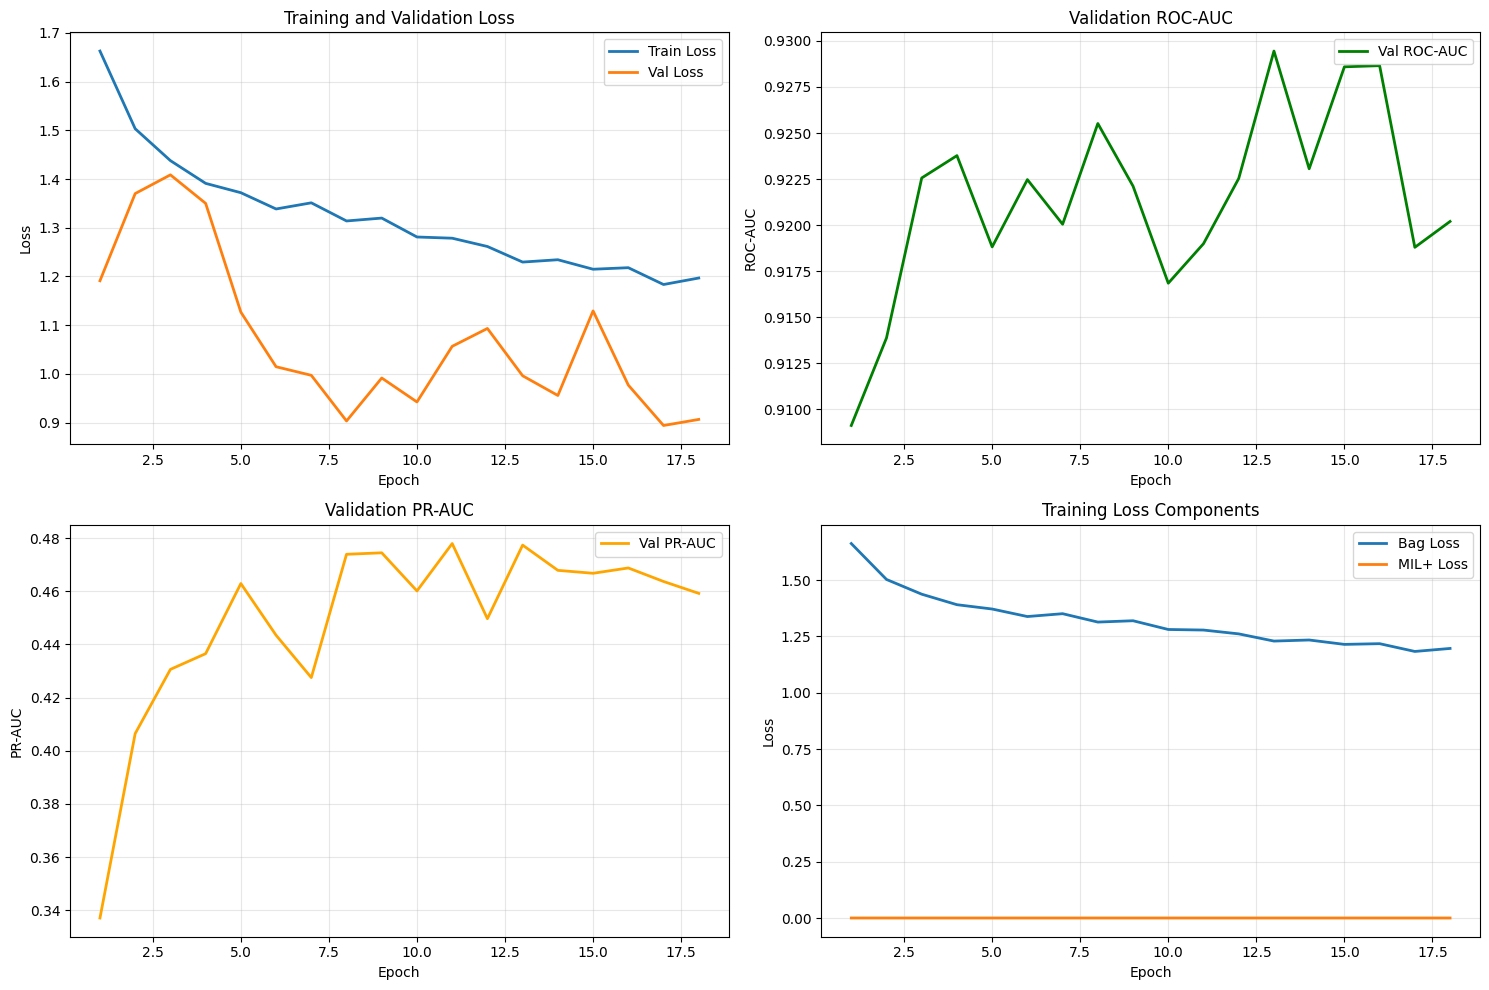

Training history plot saved to ../output/training_history.png


In [ ]:
# Extract history
history = results['history']
history_df = pd.DataFrame(history)

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training and validation loss
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ROC-AUC
axes[0, 1].plot(history_df['epoch'], history_df['val_roc_auc'], label='Val ROC-AUC', linewidth=2, color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].set_title('Validation ROC-AUC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PR-AUC
axes[1, 0].plot(history_df['epoch'], history_df['val_pr_auc'], label='Val PR-AUC', linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('PR-AUC')
axes[1, 0].set_title('Validation PR-AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MIL loss components
axes[1, 1].plot(history_df['epoch'], history_df['train_bag_loss'], label='Bag Loss', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['train_mil_pos_loss'], label='MIL+ Loss', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training Loss Components')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to {OUTPUT_DIR}/training_history.png")

## Test Set Evaluation

In [ ]:
# Test results are already in the results dict
test_metrics = results['test_metrics']
test_loss = results['test_loss']

print("\n" + "="*80)
print("FINAL TEST SET RESULTS")
print("="*80)
print(f"Test Loss: {test_loss:.4f}")
print(f"{format_metrics(test_metrics)}")
print("="*80)


FINAL TEST SET RESULTS
Test Loss: 1.0313
ROC-AUC: 0.9119 | PR-AUC: 0.4640


Generating predictions: 100%|██████████| 782/782 [00:04<00:00, 171.99it/s]


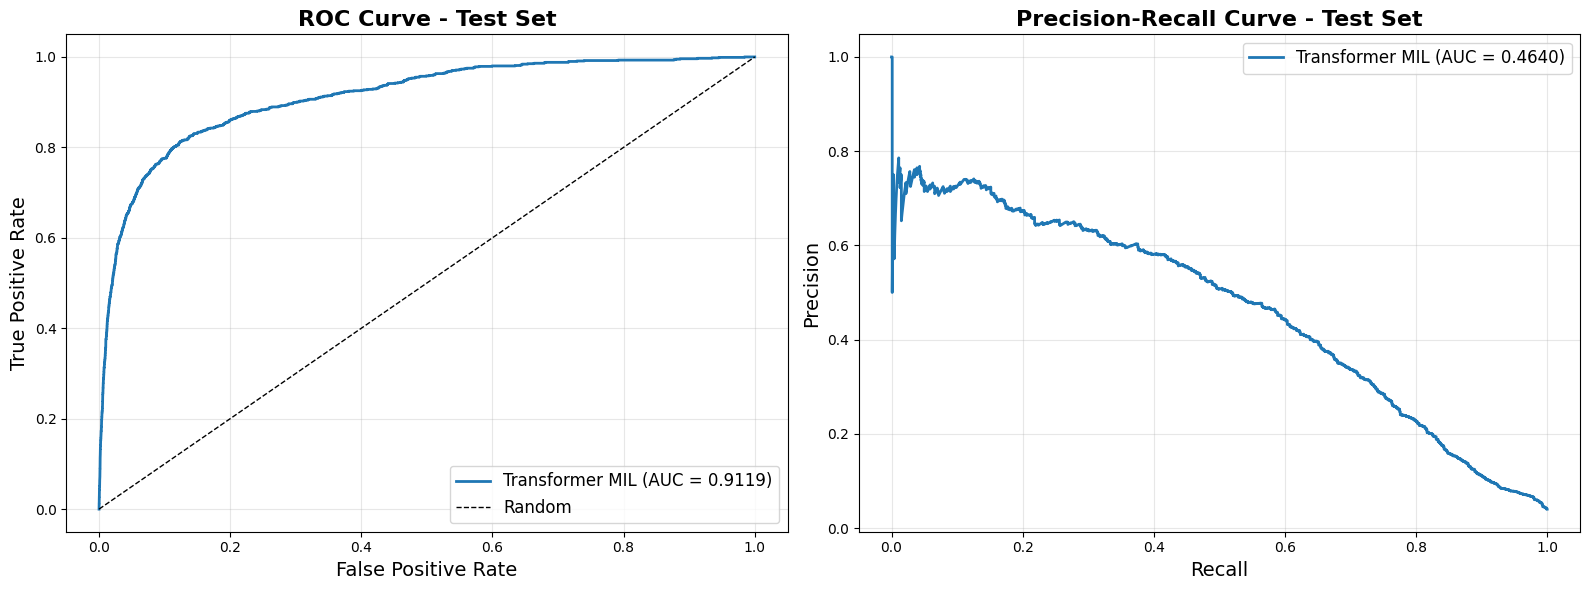

Test curves saved to ../output/test_curves.png


In [ ]:
# Get predictions on test set for plotting
model.eval()
criterion = MILLoss(alpha=0.5).to(device)

test_probs, test_labels = [], []
with torch.no_grad():
    for x_num, x_seq, mask, y in tqdm(test_loader, desc="Generating predictions"):
        x_num = x_num.to(device)
        x_seq = x_seq.to(device)
        mask = mask.to(device)
        
        bag_logits, _, _ = model(x_num=x_num, x_seq=x_seq, mask=mask)
        bag_probs = torch.sigmoid(bag_logits)
        
        test_probs.extend(bag_probs.cpu().numpy())
        test_labels.extend(y.cpu().numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)

# Plot ROC and PR curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
test_roc_auc = test_metrics['roc_auc']
axes[0].plot(fpr, tpr, linewidth=2, label=f'Transformer MIL (AUC = {test_roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=14)
axes[0].set_ylabel('True Positive Rate', fontsize=14)
axes[0].set_title('ROC Curve - Test Set', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)

# PR Curve
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
test_pr_auc = test_metrics['pr_auc']
axes[1].plot(recall, precision, linewidth=2, label=f'Transformer MIL (AUC = {test_pr_auc:.4f})')
axes[1].set_xlabel('Recall', fontsize=14)
axes[1].set_ylabel('Precision', fontsize=14)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/test_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Test curves saved to {OUTPUT_DIR}/test_curves.png")

In [ ]:
# Save test predictions
output_dir = Path(OUTPUT_DIR)
output_dir.mkdir(parents=True, exist_ok=True)

results_df = pd.DataFrame({
    'true_label': test_labels,
    'predicted_probability': test_probs
})
results_df.to_csv(output_dir / 'test_predictions.csv', index=False)
print(f"Test predictions saved to {output_dir / 'test_predictions.csv'}")

# Save training history
history_df.to_csv(output_dir / 'training_history.csv', index=False)
print(f"Training history saved to {output_dir / 'training_history.csv'}")

print(f"\nAll results saved to: {RUN_DIR}")
print("Training complete!")

In [ ]:
# Save final trained model and a full checkpoint
save_dir = Path(CHECKPOINT_DIR)
save_dir.mkdir(parents=True, exist_ok=True)

# 1) Save just the model weights (preferred for loading with the same architecture)
final_state_path = save_dir / 'final_model_state_dict.pt'
torch.save(model.state_dict(), final_state_path)

# 2) Save a full checkpoint (model + optimizer + scaler + basic training config)
final_ckpt_path = save_dir / 'final_checkpoint.pt'
final_checkpoint = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'scaler_state': scaler.state_dict() if 'scaler' in globals() and scaler is not None else None,
    'training': {
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'epochs': EPOCHS,
        'warmup_steps': WARMUP_STEPS,
    },
    'timestamp': TIMESTAMP,
}
torch.save(final_checkpoint, final_ckpt_path)

print(f"Saved final model state_dict to: {final_state_path}")
print(f"Saved final checkpoint to: {final_ckpt_path}")